In [1]:
import numpy as np
import pandas as pd
import plot_util
import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
long_nosc_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC.csv')
long_nosc_df.head()

,organism,primary_accession,gene_name,description,GO_terms,COG_IDs,KEGG_IDs,KEGG_pathways,KEGG_path_IDs,fraction_transmembrane,...,NC,NOSC,Ce_total,eC_ratio,ribosomal_protein,aminoacyl_tRNA_synthetase,amino_acid_biosynthesis,fatty_acid_biosynthesis,primary_COG_category,secondary_COG_category
0,coli,A5A605,ykfM,Uncharacterized protein YkfM,"GO:0016020,GO:0006974,GO:0046677",ENOG5031M8I,eco:b4586,NaN,NaN,0.377358,...,862.0,-0.349478,-301.25,4.349478,False,False,False,False,NaN,NaN
1,coli,P02929,tonB,Protein TonB,"GO:0030313,GO:0009279,GO:0030288,GO:0005886,GO...",COG0810,"ecj:JW5195,eco:b1252",NaN,NaN,0.129707,...,1173.0,-0.208150,-244.16,4.208150,False,False,False,False,M,NaN
2,coli,P05523,mutM,Formamidopyrimidine-DNA glycosylase,"GO:0034039,GO:0140078,GO:0003684,GO:0019104,GO...",COG0266,"ecj:JW3610,eco:b3635",Base excision repair - Escherichia coli K-12 M...,path:eco03410,0.000000,...,1358.0,-0.170685,-231.79,4.170685,False,False,False,False,L,NaN
3,coli,P06611,btuD,Vitamin B12 import ATP-binding protein BtuD,"GO:0043190,GO:1990191,GO:0019898,GO:0015420,GO...",COG4138,"ecj:JW1699,eco:b1709",ABC transporters - Escherichia coli K-12 MG1655,path:eco02010,0.000000,...,1189.0,-0.132733,-157.82,4.132733,False,False,False,False,H,NaN
4,coli,P07109,hisP,Histidine transport ATP-binding protein HisP,"GO:0055052,GO:0015424,GO:0005524,GO:0005291,GO...",COG4598,"ecj:JW2303,eco:b2306",ABC transporters - Escherichia coli K-12 MG1655,path:eco02010,0.000000,...,1266.0,-0.159415,-201.82,4.159415,False,False,False,False,E,NaN


In [3]:
# Monte Carlo sampling to estimate plausible range of proteome NOSC
eq_weight_estimates = dict(organism=[], NOSC=[], eC_ratio=[])
weighted_estimates = dict(organism=[], NOSC=[], eC_ratio=[])
# estimate a range on the coding sequence NOSC
cols2sum = 'NC,Ce_total'.split(',')
rows_mask = long_nosc_df[cols2sum].notnull().all(axis=1)


# For each organism, we sample 1000 genes across 5 orders of expression
# 1e5 times and record the NOSC of the samples. We also make an unweighted 
# estimate, but they should have the same mean. 
for gid, gdf in long_nosc_df.loc[rows_mask].groupby('organism'):
    print(gid)
    for _ in range(10000):
        # In E. coli, 1000 genes covers ≈99% of protein C atoms
        sample = gdf.sample(1000)
        s = sample[cols2sum].sum()
        
        sample_nosc = s.Ce_total / s.NC

        eq_weight_estimates['organism'].append(gid)
        eq_weight_estimates['NOSC'].append(sample_nosc)
        eq_weight_estimates['eC_ratio'].append(4 - sample_nosc)
        
        # sample expression from a log-normal with a std deviation of 3 orders
        expression = np.random.lognormal(size=1000)
        Ce_weighted = sample.Ce_total * expression
        NC_weighted = sample.NC * expression
        sample_nosc_weighted = Ce_weighted.sum() / NC_weighted.sum()
        
        weighted_estimates['organism'].append(gid)
        weighted_estimates['NOSC'].append(sample_nosc_weighted)
        weighted_estimates['eC_ratio'].append(4 - sample_nosc_weighted)
        
eq_weight_nosc_est_df = pd.DataFrame(eq_weight_estimates)
eq_weight_nosc_est_df.to_csv('../data/genomes/all_ref_prot_NOSC_unweighted_monte_carlo_samples.csv', index=False)
weighted_nosc_est_df = pd.DataFrame(weighted_estimates)
weighted_nosc_est_df.to_csv('../data/genomes/all_ref_prot_NOSC_weighted_monte_carlo_samples.csv', index=False)

PCC6803
coli
yeast


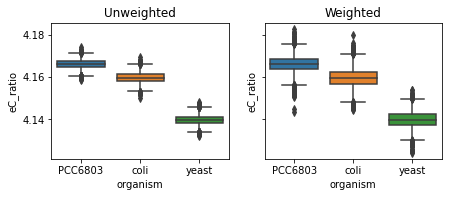

In [4]:
# Compare the weighted and unweighted samples
fig, axs = plt.subplots(ncols=2, figsize=(7,2.5), sharey=True)

plt.sca(axs[0])
sns.boxplot(data=eq_weight_nosc_est_df, x='organism', y='eC_ratio')
plt.title('Unweighted')

plt.sca(axs[1])
plt.title('Weighted')
sns.boxplot(data=weighted_nosc_est_df, x='organism', y='eC_ratio')

plt.show()